# Introduction to Model Building with Keras

Keras is a neural networks library written in Python and capable of running on top of Tensorflow and Theano. It is capable of building deep learning models with minimal time spent on the build process. Theano and Tensorflow offer extensive functionality for DIY model building but this process can be lengthy especially for those new to deep learning.

Keras is gaining popularity in the deep learning community due to its ease of use and the ability to create new models in just a few lines of code.

Keras has four guiding principles:

**Modularity** - All models are fully configurable and built from stand alone modules.

**Minimalism** - Code should be short and interpretable 

**Easy extensibility** - The intention is that new modules should be easy to add making the library useful for advanced researchers.

**Work with Python** - Models are described in Python code, which is compact, easier to debug, and allows for ease of extensibility.

This notebook will provide an introduction to using Keras and outline a simple four stage model building process.

1. [Build the model:](#Sequential-Model) Create a Sequential model, define and add configured layers.
2. [Model Compilation:](#Compile-Model) Choose the loss function and optimizers and call the compile() function on the model.
3. [Train the model:](#Train-Model) Call the fit() function to train the model using training data
4. [Make predictions:](#Evaluate-Model) Use the model to generate predictions on new data

Option - [Additional Analysis](#Additional-Model-Analysis)

Use the hyperlinks above to move straight to relevant sections of interest.

All documentation and installation instructions can be found on the Keras homepage http://keras.io/

### MNIST Handwritten Digits Example

A common dataset to practise working with neural networks is the MNIST handwritten digits dataset. The original data can be found here: http://yann.lecun.com/exdb/mnist/

To avoid using the .gz format, the data has been converted to csv by Joseph Redmon and can be found here: http://pjreddie.com/projects/mnist-in-csv/

The data exists in two files, train and test sets. Load files using Pandas.

• Amendment - I have since discovered MNIST can be accessed directly from Keras datasets if you prefer to load directly into memory without downloading the data.

In [1]:
import os
import pandas as pd
import numpy as np

# Function to load and split the training and test data into features and labels

def feature_label_split(path, data='train'):
    df = pd.read_csv(os.path.join(path,'mnist_{}.csv'.format(data)), header=None)
    y = df.iloc[:,0]
    X = df.drop(df.columns[0], axis=1)
    return X, y

In [2]:
path = '/Documents/Enrion/Datasets/'

X_train, y_train = feature_label_split(path, data='train')
print("Training Data: Rows, Columns")
print("Feature set {0} and labels {1}".format(X_train.shape, y_train.shape))

Training Data: Rows, Columns
Feature set (60000, 784) and labels (60000,)


In [3]:
X_test, y_test = feature_label_split(path, data='test')
print("Test Data: Rows, Columns")
print("Feature set {0} and labels {1}".format(X_test.shape, y_test.shape))

Test Data: Rows, Columns
Feature set (10000, 784) and labels (10000,)


Convert Data into numpy arrays

In [4]:
X_train, X_test = np.asarray(X_train), np.asarray(X_test)
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

### View First 10 images

Use matplotlib image functionality to view first 25 digits in training set

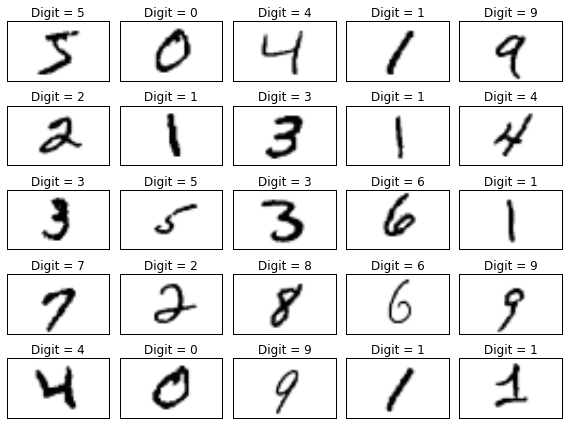

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(8,6))

num=0
for i in range(5):
    for j in range(5):
        img = X_train[num].reshape(28,28)
        ax[i][j].imshow(img, cmap='Greys')
        ax[i][j].set_title('Digit = {}'.format(y_train[num]))
        num += 1
        
ax[0][0].set_yticks([])
ax[0][0].set_xticks([])
plt.tight_layout()
plt.show()

Class labels must be one hot encoded in order to use a softmax layer as the final output to our MLP

Import the np_utils function from Keras: https://github.com/fchollet/keras/blob/master/keras/utils/np_utils.py

In [6]:
from keras.utils import np_utils

y_train_ohe = np_utils.to_categorical(y_train)

for i in range(5):
    print("Original label: {0} --- One hot encoded: {1}".format(y_train[i], y_train_ohe[i]))

Original label: 5 --- One hot encoded: [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
Original label: 0 --- One hot encoded: [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Original label: 4 --- One hot encoded: [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
Original label: 1 --- One hot encoded: [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
Original label: 9 --- One hot encoded: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


# Sequential Model

We are now ready to start building a model.

The first stage in a model build is to create a sequential model and add layers.

A sequential model can be created by passing a list of layers to a constructor or by calling an instance and then using the .add()

In [7]:
from keras.models import Sequential

# Set a random seed so the model is replicable 
np.random.seed(0) 

# Call instance of model
model = Sequential()

Using Theano backend.
/Users/Nick/anaconda/lib/python3.4/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


### Adding Layers

The .add() function can be used to start adding layers.

Dense is used to connect your neural network

Full list of args and kwargs can be found for the core layers at http://keras.io/layers/core/

**Input Layer**

The first layer must receive information about the size of the input layer. Subsequent layers can use model inference and do not need to be explicitly declared.

If declared, the input layer must equal the preceeding output layer.

Initialisation and activation functions can be declared for each layer:

Initializations define the probability distribution used to set the initial random weights of Keras layers.
Choices for initialisation - http://keras.io/initializations/

Choices for activations - http://keras.io/activations/

**Multi Layer Perceptron**

The following MLP model is taken from the book 'Python Machine Learning' written by Sebastian Raschka.

Link to github: https://github.com/rasbt/python-machine-learning-book

A uniform distribution is chosen for initialising the random weights, hyperbolic tangent activation function is chosen for layers one and two. This produces an output in the range [-1,1]. The final layer uses a softmax activation function, the output of the final layer must of course be equal to the number of classes in the data.

Optimization: The chosen method of optimization for this model is Stochastic Gradient Descent. Keras supports numerous optimizers, SGD can take learning rate, decay, momentum and Nesterov args.

http://keras.io/optimizers/#usage-of-optimizers

In [8]:
from keras.layers.core import Dense
from keras.optimizers import SGD

model.add(Dense(input_dim=X_train.shape[1], 
                output_dim=50, 
                init='uniform', 
                activation='tanh'))

model.add(Dense(input_dim=50, 
                output_dim=50, 
                init='uniform', 
                activation='tanh'))

model.add(Dense(input_dim=50, 
                output_dim=y_train_ohe.shape[1], 
                init='uniform', 
                activation='softmax'))

sgd = SGD(lr=0.001, decay=1e-7, momentum=.9, nesterov=False)

# Compile Model

The 2nd stage of the model build is to compile the model. 

Compilation configures the learning process. Three arguments are required for compilation:

1) An optimizer - see above

2) A loss function - Minimisation objective: http://keras.io/objectives/

3) Metrics - Choice of metrics can be passed as a list of strings

In [9]:
model.compile(optimizer=sgd, loss='categorical_crossentropy')

# Train Model

Keras models are trained on Numpy arrays of input data and labels. For training a model, you call the fit function.

Available args can be found here: http://keras.io/models/sequential/


In [10]:
model.fit(X_train, y_train_ohe, 
          nb_epoch=50, 
          batch_size=300, 
          verbose=1, 
          validation_split=0.1, 
          show_accuracy=True)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 4s - loss: 2.2375 - acc: 0.3643 - val_loss: 2.1290 - val_acc: 0.5520
Epoch 2/50
54000/54000 [==============================] - 2s - loss: 1.9214 - acc: 0.5564 - val_loss: 1.6397 - val_acc: 0.5938
Epoch 3/50
54000/54000 [==============================] - 2s - loss: 1.3990 - acc: 0.6303 - val_loss: 1.1365 - val_acc: 0.7077
Epoch 4/50
54000/54000 [==============================] - 2s - loss: 1.0018 - acc: 0.7552 - val_loss: 0.8117 - val_acc: 0.8343
Epoch 5/50
54000/54000 [==============================] - 2s - loss: 0.7598 - acc: 0.8321 - val_loss: 0.6211 - val_acc: 0.8782
Epoch 6/50
54000/54000 [==============================] - 2s - loss: 0.6183 - acc: 0.8595 - val_loss: 0.5167 - val_acc: 0.8927
Epoch 7/50
54000/54000 [==============================] - 2s - loss: 0.5374 - acc: 0.8718 - val_loss: 0.4539 - val_acc: 0.8952
Epoch 8/50
54000/54000 [==============================] - 2s -

# Evaluate Model

Use the predict()function to make predictions on new data or to evaluate model accuracy on unseen labelled data.

Evaluate performance on the training data


In [11]:
# Use model.predict to obtain probability scores for each class
y_train_pred_prob = model.predict(X_train, batch_size = 300, verbose =0)

# Use model.predict_classes to obtain class prediction
y_train_pred_class = model.predict_classes(X_train, batch_size = 300, verbose =0)

print("Example row of predictions for each class: \n{}".format(y_train_pred_prob[0]))

print("\nClass prediction: {} with {:.2%} probability".format(y_train_pred_class[0], max(y_train_pred_prob[0])))


Example row of predictions for each class: 
[  1.55718876e-02   1.33522169e-03   1.76009067e-04   1.36018425e-01
   7.16690101e-06   8.39708805e-01   2.69585900e-04   3.12017306e-04
   6.01303810e-03   5.87856281e-04]

Class prediction: 5 with 83.97% probability


In [12]:
train_acc = np.sum(y_train_pred_class == y_train) / len(y_train)

print("Training accuracy: {:.2%}".format(train_acc))

Training accuracy: 94.45%


Apply model to labelled test data and evaluate accuracy

In [13]:
y_test_ohe = np_utils.to_categorical(y_test)

y_test_predictions = model.predict_classes(X_test, batch_size=300, verbose=1)

test_acc = np.sum(y_test_predictions == y_test) / len(y_test)

print("Test accuracy: {:.2%}".format(test_acc))

10000/10000 [==============================] - 0s     
Test accuracy: 94.20%


### Additonal Model Analysis

We can create a DataFrame of Predictions, Actual Label, Probability

This could potentially be analysed to evaluate uncertainty associated with each class or individual predictions

In [14]:
# Collect probabilities for each example
y_test_proba = model.predict(X_test, batch_size=300, verbose=0)

probabilities = [max(x) for x in y_test_proba]

df = pd.DataFrame( {'Actual': y_test,
                   'Predicted': y_test_predictions,
                   "Probability": probabilities})

df.head()

,Actual,Predicted,Probability
0,7,7,0.996396
1,2,2,0.970583
2,1,1,0.996949
3,0,0,0.985808
4,4,4,0.967633


In [15]:
print("Number of correct predictions with probability:")
for i in np.arange(0,1,0.05):
    certaintyGT = [(df.Actual == df.Predicted) & (df.Probability > i)]
    print(" > {}%: {}".format(int(i*100),sum(certaintyGT[0])))

Number of correct predictions with probability:
 > 0%: 9420
 > 5%: 9420
 > 10%: 9420
 > 15%: 9420
 > 20%: 9420
 > 25%: 9419
 > 30%: 9418
 > 35%: 9412
 > 40%: 9397
 > 45%: 9360
 > 50%: 9319
 > 55%: 9262
 > 60%: 9186
 > 65%: 9092
 > 70%: 8976
 > 75%: 8812
 > 80%: 8637
 > 85%: 8361
 > 90%: 7899
 > 95%: 6949


Plot a line graph showing the % of correct predictions against the models assigned probability

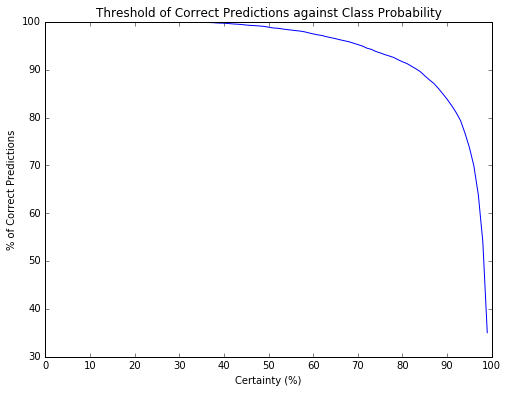

In [16]:
x_axis = np.arange(0,1,0.01)
count = []

for i in x_axis:
    count.append(sum([(df.Actual == df.Predicted) & (df.Probability > i)][0]))

x_axis = [x*100 for x in x_axis]
count = [(x*100) / np.max(count) for x in count]    
    
fig = plt.figure(figsize = (8,6))
plt.plot(x_axis, count)
plt.xlabel('Certainty (%)')
plt.ylabel('% of Correct Predictions')
plt.title('Threshold of Correct Predictions against Class Probability')
plt.xticks(np.arange(0,101,10))
plt.show()

Plot a line graph showing the % of incorrect predictions against the models assigned probability

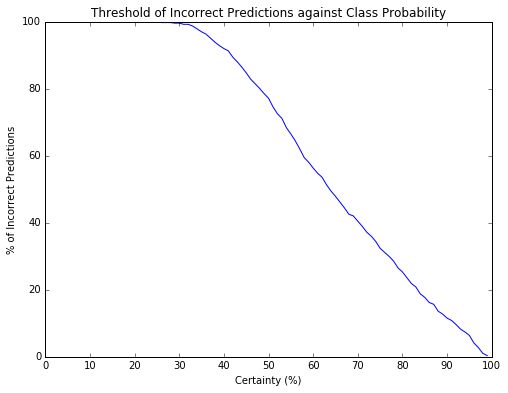

In [17]:
x_axis = np.arange(0,1,0.01)
count = []

for i in x_axis:
    count.append(sum([(df.Actual != df.Predicted) & (df.Probability > i)][0]))

x_axis = [x*100 for x in x_axis]
count = [(x*100) / np.max(count) for x in count]    
    
fig = plt.figure(figsize = (8,6))
plt.plot(x_axis, count)
plt.xlabel('Certainty (%)')
plt.ylabel('% of Incorrect Predictions')
plt.title('Threshold of Incorrect Predictions against Class Probability')
plt.xticks(np.arange(0,101,10))
plt.show()

Create lists of total number of images per class and total number predicted correctly

In [18]:
totals = []
class_count_list = []

classes = np.sort(df.Actual.unique())

for i in range(10):
    total_class_count = df[df.Actual == i].shape[0]
    class_count_list.append(total_class_count)
    df_filter = df[df.Actual == i]
    total_correct = sum(df_filter.Actual == df_filter.Predicted)
    totals.append(total_correct)

print(class_count_list)
print(totals)

[980, 1135, 1032, 1010, 982, 892, 958, 1028, 974, 1009]
[964, 1110, 975, 934, 930, 816, 924, 954, 900, 913]


Plot as a barchart

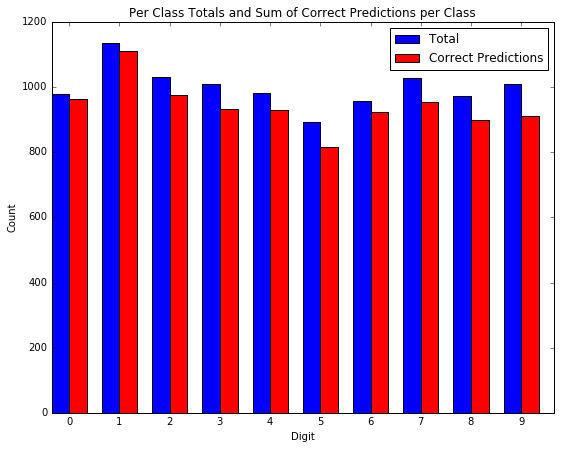

In [33]:
width=0.35
fig, ax = plt.subplots(figsize=(9,7))
plot1 = ax.bar(classes, class_count_list, width=width, color='b')
plot2 = ax.bar(classes+width, totals, width= width, color='r')
ax.set_ylabel('Count')
ax.set_xlabel('Digit')
ax.set_title('Per Class Totals and Sum of Correct Predictions per Class')
ax.set_xticks(classes + width)
ax.set_xticklabels(np.arange(10))
ax.legend((plot1[0], plot2[0]), ('Total', 'Correct Predictions'))
plt.show()

Identify the digits that the MLP struggled with:

Problem numbers: 3, 5, 7, 8, 9

In [20]:
percent_correct = [totals[x] / class_count_list[x] for x in range(10)]

print("Digit : Accuracy")
for i in range(10):
    print("{}   :   {:.2f}".format(classes[i],percent_correct[i]))

Digit : Accuracy
0   :   0.98
1   :   0.98
2   :   0.94
3   :   0.92
4   :   0.95
5   :   0.91
6   :   0.96
7   :   0.93
8   :   0.92
9   :   0.90
